In [2]:
import itertools
import os
import random
import shutil
import time
from tqdm.notebook import tqdm
import uuid
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import matplotlib.pyplot as plt

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

# Config

In [4]:
TRAIN_ON_TF = 'TF_2'
TRAIN_PROBE = 'A'
TEST_PROBE = 'B'
MOTIF_LEN = 24
NUM_MOTIF_DETECTORS=16
BATCH_SIZE = 64

In [5]:
DNA_BASES = 'ACGT'
RNA_BASES = 'ACGU'

In [6]:
PBM_DATA = "/home/vazzu/Desktop/bioinfo/compbio-final/data/dream5/pbm"

# Data preparation

### Read DREAM5 sequence data with binding scores

In [7]:
df_seq = pd.read_csv(f"{PBM_DATA}/sequences.tsv", sep='\t')
df_seq.head()

,Fold ID,Event ID,seq
0,B,MEreverse14075,TAAAACTATGAGGAAGGATTCAGGGTCGGACAGTGCCTGT
1,B,MEforward19438,CTTATGATCAGAAGCGGCTAGGTGTATTACATGTCCCTGT
2,B,MEforward19439,CCGCCGTAGGCCCCGAAACAGTACCAGACATGTAACCTGT
3,B,MEforward19436,GACCAAACGAGTCCTAGGATTCCAAGCGTTACGACCCTGT
4,B,MEforward19437,CGTTACGACGGAGTTTGGATCCCGAACTTATGATCCCTGT


In [8]:
df_targets = pd.read_csv(f"{PBM_DATA}/targets.tsv", sep='\t')
df_targets.head()

,TF_40,TF_41,TF_42,TF_43,TF_44,TF_45,TF_46,TF_47,TF_48,TF_49,...,C_19,C_18,C_15,C_14,C_17,C_16,C_11,C_10,C_13,C_12
0,823.914118,12702.625538,2124.023125,2314.305782,1474.888697,1131.785521,4597.003319,14589.890994,1556.951404,34180.775942,...,1651.254953,1242.303363,724.105850,3184.883349,8935.394363,12689.558779,4102.312624,505.126184,12946.381724,1313.790253
1,1307.840222,4316.426121,2554.658908,3415.320661,3408.586803,1697.342725,5272.763446,22903.130555,2181.551097,10000.297243,...,3505.604759,2516.000120,1640.114829,3463.713253,19535.468264,18006.721690,6890.427794,1402.597000,38309.856355,3024.107809
2,1188.353499,3436.803941,2088.909658,3708.324021,2219.741833,1571.646567,6225.376501,13858.014077,1971.053716,18800.025304,...,3270.572883,1693.419147,997.792996,3196.992198,16695.027604,14486.992627,13517.968701,10680.866586,25648.825592,2675.530918
3,1806.103795,6531.268855,2406.186212,3601.204703,2828.415329,2746.861783,5810.104650,25701.749693,2191.273065,19213.880658,...,2701.555739,2059.614815,1432.163042,4927.163643,18896.765835,18784.043322,8608.167421,4624.044391,23651.726053,3679.449867
4,1417.411525,3951.243575,2581.309532,3375.884699,2764.716964,1806.919566,5033.976283,26364.859152,2311.790793,16139.097553,...,2457.214141,1901.709222,1672.531034,3877.787322,14699.253953,17119.871513,8995.328144,12641.425965,27999.405431,3128.844808


### Build a dataframe for single transcription factor

In [24]:
def build_df(tf, df_seq, df_targets):
    df = df_seq.copy()
    df["Target"] = df_targets[tf].values
    return df

In [25]:
df = build_df(TRAIN_ON_TF, df_seq, df_targets)
df.head()

,Fold ID,Event ID,seq,Target
0,B,MEreverse14075,TAAAACTATGAGGAAGGATTCAGGGTCGGACAGTGCCTGT,2941.528352
1,B,MEforward19438,CTTATGATCAGAAGCGGCTAGGTGTATTACATGTCCCTGT,6646.004089
2,B,MEforward19439,CCGCCGTAGGCCCCGAAACAGTACCAGACATGTAACCTGT,4606.883308
3,B,MEforward19436,GACCAAACGAGTCCTAGGATTCCAAGCGTTACGACCCTGT,8126.753206
4,B,MEforward19437,CGTTACGACGGAGTTTGGATCCCGAACTTATGATCCCTGT,7935.937598


In [26]:
df['Target'].mean()

np.float64(4223.027893532133)

In [13]:
df['Target'].std()

np.float64(4568.640213013825)

### Remove probe specific biases for each sequence

In [27]:
biases = df_targets.median(axis=1).values
biases

array([2641.988164 , 4170.2475   , 3699.8877625, ..., 2287.3149815,
       1884.915039 , 1231.9427485], shape=(80856,))

In [29]:
df['TargetNorm'] = df['Target'].values / biases
df.head()

,Fold ID,Event ID,seq,Target,TargetNorm
0,B,MEreverse14075,TAAAACTATGAGGAAGGATTCAGGGTCGGACAGTGCCTGT,2941.528352,1.113377
1,B,MEforward19438,CTTATGATCAGAAGCGGCTAGGTGTATTACATGTCCCTGT,6646.004089,1.593671
2,B,MEforward19439,CCGCCGTAGGCCCCGAAACAGTACCAGACATGTAACCTGT,4606.883308,1.245141
3,B,MEforward19436,GACCAAACGAGTCCTAGGATTCCAAGCGTTACGACCCTGT,8126.753206,1.758181
4,B,MEforward19437,CGTTACGACGGAGTTTGGATCCCGAACTTATGATCCCTGT,7935.937598,2.046512


### Calculate NA content and drop rows

In [31]:
# Only 4% NA content, it is safe to drop the rows
df['Target'].isna().mean()

np.float64(0.04049173839912932)

In [32]:
df.dropna(subset=['Target'], inplace=True)
df['Target'].isna().mean()

np.float64(0.0)

### Train/Test data split

In [60]:
df_train = df[df['Fold ID'] == TRAIN_PROBE]
df_train.head()

,Fold ID,Event ID,seq,Target,TargetNorm
40526,A,HK26479,ACGCGCGTCAGCTTTTTGGAATATTGCGGAGAGTTCCTGT,1894.891681,0.713724
40527,A,HK26478,GACTATGGGATGGGCCGCCTTTGATTACGCGCGTCCCTGT,3041.923394,1.000000
40528,A,HK22998,CCTTCGTGAGCCATGTGTTTCAGGCTGTGCGTGTCCCTGT,1876.956557,0.790750
40529,A,HK22999,GGCGGGTGGTAAAGGCCCCGGAAGCGGACACGCACCCTGT,1048.948759,0.622457
40530,A,HK26473,GTTGTGGTTTGTCCTTTTGTATTAACAGTGTATGGCCTGT,2343.217193,0.626426


In [61]:
df_test = df[df['Fold ID'] == TEST_PROBE]
df_test.head()

,Fold ID,Event ID,seq,Target,TargetNorm
0,B,MEreverse14075,TAAAACTATGAGGAAGGATTCAGGGTCGGACAGTGCCTGT,2941.528352,1.113377
1,B,MEforward19438,CTTATGATCAGAAGCGGCTAGGTGTATTACATGTCCCTGT,6646.004089,1.593671
2,B,MEforward19439,CCGCCGTAGGCCCCGAAACAGTACCAGACATGTAACCTGT,4606.883308,1.245141
3,B,MEforward19436,GACCAAACGAGTCCTAGGATTCCAAGCGTTACGACCCTGT,8126.753206,1.758181
4,B,MEforward19437,CGTTACGACGGAGTTTGGATCCCGAACTTATGATCCCTGT,7935.937598,2.046512


In [62]:
df_train.shape, df_test.shape

((38041, 5), (39541, 5))

### Add labels for ROC and AUC

In [63]:
# DREAM5 https://pmc.ncbi.nlm.nih.gov/articles/PMC3687085/
def add_label(d):
    # Add positive label to only rows with binding score higher than mean + 4*std
    mean = d['Target'].mean()
    std = d['Target'].std()
    lower_limit = mean + 4*std

    # Limits MAX: 1300 rows MIN: 50 rows
    top = d[d['Target'] > lower_limit].copy()
    if len(top) >= 50:
        top = top.sort_values(by='Target', ascending=False).head(1300)
    else:
        top = d.sort_values(by='Target', ascending=False, inplace=False).head(50)

    d['Label'] = 0
    d.loc[top.index, 'Label'] = 1

In [65]:
add_label(df_train)
df_train.head()

,Fold ID,Event ID,seq,Target,TargetNorm,Label
40526,A,HK26479,ACGCGCGTCAGCTTTTTGGAATATTGCGGAGAGTTCCTGT,1894.891681,0.713724,0
40527,A,HK26478,GACTATGGGATGGGCCGCCTTTGATTACGCGCGTCCCTGT,3041.923394,1.000000,0
40528,A,HK22998,CCTTCGTGAGCCATGTGTTTCAGGCTGTGCGTGTCCCTGT,1876.956557,0.790750,0
40529,A,HK22999,GGCGGGTGGTAAAGGCCCCGGAAGCGGACACGCACCCTGT,1048.948759,0.622457,0
40530,A,HK26473,GTTGTGGTTTGTCCTTTTGTATTAACAGTGTATGGCCTGT,2343.217193,0.626426,0


In [67]:
df_train[df_train['Label'] == 1].head()

,Fold ID,Event ID,seq,Target,TargetNorm,Label
40545,A,HK37117,ATAGATGATTGCCTAATAGAACCTACACAGTAAACCCTGT,23505.012865,6.751061,1
40630,A,HK39222,AGGTGTTACATATATCAGCTTGGGTGGATACCCGACCTGT,19403.494948,7.323275,1
40751,A,HK31683,GGCATTCAGGACAATTAGATAACCCAAGCGTAGCCCCTGT,20245.802138,8.385751,1
40775,A,HK34305,TGTATTGCATAAACGTTCCAGGACCCCTGGCTCACCCTGT,33224.921774,14.948550,1
40961,A,HK15380,TGTATGATCACCAACTCATGGTTGCGCAATGAACCCCTGT,22591.018693,7.530934,1


In [64]:
add_label(df_test)
df_test.head()

,Fold ID,Event ID,seq,Target,TargetNorm,Label
0,B,MEreverse14075,TAAAACTATGAGGAAGGATTCAGGGTCGGACAGTGCCTGT,2941.528352,1.113377,0
1,B,MEforward19438,CTTATGATCAGAAGCGGCTAGGTGTATTACATGTCCCTGT,6646.004089,1.593671,0
2,B,MEforward19439,CCGCCGTAGGCCCCGAAACAGTACCAGACATGTAACCTGT,4606.883308,1.245141,0
3,B,MEforward19436,GACCAAACGAGTCCTAGGATTCCAAGCGTTACGACCCTGT,8126.753206,1.758181,0
4,B,MEforward19437,CGTTACGACGGAGTTTGGATCCCGAACTTATGATCCCTGT,7935.937598,2.046512,0


In [70]:
df_test[df_test['Label'] == 1].head()

,Fold ID,Event ID,seq,Target,TargetNorm,Label
149,B,MEforward05359,TAAGAAAAGATTTTTACGTAACATGTCTACTCTGGCCTGT,54999.072022,15.626592,1
598,B,MEreverse19582,ATCGAGTCGGCTTTACAATTACATAATCTAAGCTACCTGT,72179.964196,10.621469,1
640,B,MEforward05965,AGCTACATGTAGCTCGGCATTTATATAACCCACTGCCTGT,26433.473625,5.848461,1
769,B,MEreverse06558,ATTCTAACGACTGTGACATAATGACCCCACCTCGGCCTGT,28221.317418,5.393725,1
825,B,MEreverse08764,TACGCATTTACGTTGCATAATCTTGTGAGTAGCAGCCTGT,54040.187164,10.802248,1


### DNA/RNA sequence to Matrix logic

In [71]:
def fill_cell(motif_len, row, col, bases, seq):
    num_rows = len(seq) + 2 * motif_len - 2
    
    # First M-1 rows are filled with 0.25
    if row < motif_len-1:
        return 0.25

    # Last M-1 rows are filled with 0.25
    if num_rows-1-row < motif_len-1:
        return 0.25

    idx = row - motif_len + 1
    if seq[idx] == bases[col]:
        return 1.0

    return 0.0

def seq2matrix(seq, motif_len, typ='DNA'):
    bases = DNA_BASES if typ == 'DNA' else RNA_BASES
    num_rows = len(seq) + 2 * motif_len - 2
    result = np.empty([num_rows, 4])
    for row in range(num_rows):
        for col in range(4):
            result[row, col] = fill_cell(motif_len, row, col, bases, seq)
    return np.transpose(result)

In [72]:
# Test the function
S = seq2matrix("ATGG", 3, 'DNA')
S

array([[0.25, 0.25, 1.  , 0.  , 0.  , 0.  , 0.25, 0.25],
       [0.25, 0.25, 0.  , 0.  , 0.  , 0.  , 0.25, 0.25],
       [0.25, 0.25, 0.  , 0.  , 1.  , 1.  , 0.25, 0.25],
       [0.25, 0.25, 0.  , 1.  , 0.  , 0.  , 0.25, 0.25]])

In [73]:
S.shape

(4, 8)

### Sequence Dataset and Loader

In [104]:
class SeqDataset(Dataset):
    def __init__(self, df):
        self.sequences = df['seq'].values
        self.targets = df['TargetNorm'].values
        self.labels = df['Label'].values

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        
        M = seq2matrix(seq, MOTIF_LEN, 'DNA')
        
        x = torch.tensor(M, dtype=torch.float32)
        y = torch.tensor(self.targets[idx], dtype=torch.float32)
        label = self.labels[idx].copy()
        
        return x, y, label

In [105]:
train_dataset = SeqDataset(df_train)
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

In [106]:
xs, ys, labels = [], [], []

for x, y, label in train_dataset:
    xs.append(x)
    ys.append(y)
    labels.append(label)

x_train = torch.stack(xs)
y_train = torch.tensor(ys, dtype=torch.float32)
label_train = torch.tensor(labels)

In [107]:
x, target, label = next(iter(train_loader))
x.shape, target.shape, label.shape

(torch.Size([64, 4, 86]), torch.Size([64]), torch.Size([64]))

In [108]:
test_dataset = SeqDataset(df_test)

xs, ys, labels = [], [], []

for x, y, label in train_dataset:
    xs.append(x)
    ys.append(y)
    labels.append(label)

x_test = torch.stack(xs)
y_test = torch.tensor(ys, dtype=torch.float32)
label_test = torch.tensor(labels)

In [109]:
x_test.shape, y_test.shape, label_test.shape

(torch.Size([38041, 4, 86]), torch.Size([38041]), torch.Size([38041]))

# Model

### DeepBind Model

In [110]:
import torch.nn as nn
import torch.nn.functional as F

class DeepBindShallow(nn.Module):
    def __init__(self, num_motif_detectors, motif_len):
        super().__init__()

        self.conv = nn.Conv1d(in_channels=4, out_channels=num_motif_detectors, kernel_size=motif_len)
        self.fc = nn.Linear(num_motif_detectors, 1)

    def forward(self, x):
        
        x = self.conv(x)
        x = F.relu(x)
        x, _ = torch.max(x, dim=2)
        x = self.fc(x)

        return x

In [111]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

class DeepBind(nn.Module):
    def __init__(self, num_motif_detectors, motif_len):
        super().__init__()

        self.conv = nn.Conv1d(in_channels=4, out_channels=num_motif_detectors, kernel_size=motif_len)
        self.fc1 = nn.Linear(num_motif_detectors, 32)
        self.fc2 = nn.Linear(32, 1)

        self.init_weights(self.conv)
        self.init_weights(self.fc1)
        self.init_weights(self.fc2)

    def init_weights(self, component):
        init.kaiming_normal_(component.weight, nonlinearity='relu')
        init.zeros_(component.bias)
    
    def forward(self, x):
        
        x = self.conv(x)
        x = F.relu(x)
        x, _ = torch.max(x, dim=2)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x

### Model Wrapper for training

In [130]:
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

class ModelWrapper:
    def __init__(self, m):
        self.model = m.to(DEVICE)
        self.opt = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.criterion = torch.nn.MSELoss()

    def train_step(self, x, target):
        self.model.train()
        
        x = x.to(DEVICE)
        target = target.to(DEVICE)

        self.opt.zero_grad()

        pred = self.model(x)
        loss = self.criterion(pred.squeeze(), target)

        loss.backward()
        self.opt.step()
        
        return loss.item()

    def predict(self, x):
        self.model.eval()
        x = x.to(DEVICE)
        pred = self.model(x).squeeze()
        pred = pred.detach().cpu().numpy()
        return pred

    def evaluate(self, x, y_true, label_true):
        y_pred = self.predict(x)

        fpr, tpr, thresholds = roc_curve(label_true, y_pred)
        roc_auc = auc(fpr, tpr)
        
        pearson_corr, _ = pearsonr(y_true, y_pred)
        spearman_corr, _ = spearmanr(y_true, y_pred)

        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.show()

        return {
            'pearson': pearson_corr,
            'spearman': spearman_corr,
            'auc': roc_auc,
        }

    def train_one_epoch(self, loader):
        epoch_loss = 0
        for i, (x, y, label) in enumerate(tqdm(loader)):
            epoch_loss += self.train_step(x, y)
        epoch_loss = epoch_loss / len(loader)
        return epoch_loss

### Sanity Check: Overfit on single mini-batch

In [131]:
x, y, label = next(iter(train_loader))
x.shape, y.shape, label.shape

(torch.Size([64, 4, 86]), torch.Size([64]), torch.Size([64]))

In [132]:
m_sanity = DeepBind(num_motif_detectors=NUM_MOTIF_DETECTORS, motif_len=MOTIF_LEN)

In [133]:
mw_sanity = ModelWrapper(m_sanity)

In [134]:
for i in range(10000):
    loss = mw_sanity.train_step(x, y)
    if i % 1000 == 0:
        print(loss)

15.527420997619629
1.589700593385146e-13
1.2505274593621607e-13
2.4606705562035813e-13
4.595768210435835e-13
1.5165646516379638e-13
1.7252865802674933e-13
3.7703173916270316e-13
2.00825467366883e-13
2.2880308758743695e-13


In [135]:
pred_sanity = mw_sanity.predict(x)
pred_sanity[:10]

array([0.89102113, 0.61314905, 0.9743315 , 0.93301857, 0.8209809 ,
       0.7634305 , 5.626388  , 0.7899271 , 0.50587523, 0.4403702 ],
      dtype=float32)

In [136]:
target_sanity = y.cpu().numpy()
target_sanity[:10]

array([0.8910211 , 0.61314905, 0.9743318 , 0.9330178 , 0.8209801 ,
       0.76343   , 5.6263876 , 0.7899273 , 0.5058757 , 0.44037035],
      dtype=float32)

In [137]:
for name, p in mw_sanity.model.named_parameters():
    print(name, p.data.abs().mean().item())

conv.weight 0.141343355178833
conv.bias 0.03039270080626011
fc1.weight 0.2987496852874756
fc1.bias 0.02551138401031494
fc2.weight 0.25687944889068604
fc2.bias 0.0010131634771823883


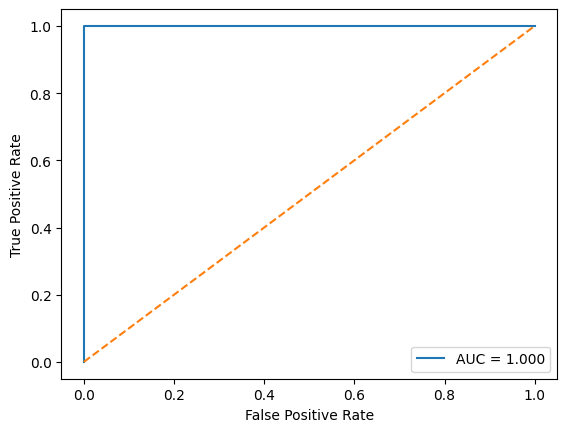

{'pearson': np.float32(1.0),
 'spearman': np.float64(0.9999999999999998),
 'auc': 1.0}

In [138]:
mw_sanity.evaluate(x, y, label)

# Training

In [139]:
def train(mw, loader, epochs):
    for epoch in range(1, epochs+1):
        print(f"===== EPOCH {epoch} =====")
        epoch_loss = mw.train_one_epoch(loader)
        print(f"Loss: {epoch_loss}")

In [140]:
m = DeepBind(num_motif_detectors=NUM_MOTIF_DETECTORS, motif_len=MOTIF_LEN)

In [141]:
mw = ModelWrapper(m)

In [ ]:
train(mw, train_loader, 30)

===== EPOCH 1 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 2.014864918752378
===== EPOCH 2 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.7323368076141141
===== EPOCH 3 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 1.229173540893723
===== EPOCH 4 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.8405268227352816
===== EPOCH 5 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.6104445148728975
===== EPOCH 6 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.5186287248648015
===== EPOCH 7 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.4367093516998932
===== EPOCH 8 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.3910818067700172
===== EPOCH 9 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.3415584267375349
===== EPOCH 10 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.3075754397994831
===== EPOCH 11 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.2801424890819217
===== EPOCH 12 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.26764729316933317
===== EPOCH 13 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.24330893574955584
===== EPOCH 14 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.2119597508282471
===== EPOCH 15 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.1973868873502527
===== EPOCH 16 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.18480191208234353
===== EPOCH 17 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.16988314420548306
===== EPOCH 18 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.1639058371082324
===== EPOCH 19 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.15911995017228006
===== EPOCH 20 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.14590059853151066
===== EPOCH 21 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.13612819588860545
===== EPOCH 22 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.14330221134073595
===== EPOCH 23 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.13658806120022005
===== EPOCH 24 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.1311703830863498
===== EPOCH 25 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.12761596231525685
===== EPOCH 26 =====


  0%|          | 0/595 [00:00<?, ?it/s]

Loss: 0.13101744902234116
===== EPOCH 27 =====


  0%|          | 0/595 [00:00<?, ?it/s]

In [164]:
mw.evaluate(x_test, y_test)

{'pearson': np.float32(0.54699504), 'spearman': np.float64(0.3566680088846224)}

In [166]:
mw.evaluate(x_train, y_train)

{'pearson': np.float32(0.9737026), 'spearman': np.float64(0.5306100004864945)}